In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
try:
    import timm
except ImportError:
    print("Please install timm: pip install timm")
    timm = None
from tqdm import tqdm

C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from lrp import lrp_engine, checkpoint_hook
from lrp_graph import make_graph

In [4]:
# Load a pretrained ViT model (trained on ImageNet)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_vit_model():

    vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
    vit_model.eval()
    
    for block in vit_model.blocks:
        block.attn.register_forward_hook(checkpoint_hook)
    return vit_model

# Load a couple of dog and cat images from ImageNet (torchvision)
def get_imagenet_samples(num_samples=2):
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    # Download ImageNet val subset (tiny-imagenet or use CIFAR10 for demo)
    # TODO: Mybe we should use a Hi Res dataset instead for the examples
    dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    # Class 3 = cat, Class 5 = dog
    imgs_list = []
    labels_list = []
    for image, label in dataset:
        if label in [3, 5]:
            imgs_list.append(image)
            labels_list.append(label)
        if len(imgs_list) >= num_samples:
            break
    return imgs_list, labels_list

#Run forward pass and get prediction
def predict(model, img_tensor):
    with torch.no_grad():
        output_tensor = model(img_tensor)
        pred_idx = output_tensor.argmax(dim=1).item()
    return output_tensor, pred_idx

# Run LRP_promises  to get patch attributions. Not sure I have initialize first
# but it should be ok because all images are of the same size
def get_patch_attributions(model, img_tensor, pred_class, out_adj_list=None, topo_exec_order=None, fcn_map=None, param_node_inds=None):
    img_tensor.requires_grad_(True)
    output = model(img_tensor)

    # Extract hidden states if available
    hidden_states = None
    if hasattr(output, 'hidden_states'):
        hidden_states = output.hidden_states
    elif isinstance(output, tuple) and len(output) > 1:
        hidden_states = output[1]
    elif isinstance(output, torch.Tensor):
        hidden_states = output
    else:
        raise RuntimeError('Could not extract hidden states from model output.')
    # Call lrp_engine as in the DNABERT-2 notebook
    # return make_graph(hidden_states.half())
    # if input_ind is None:
    #     input_ind = img_tensor
    if param_node_inds is None:
        lrp_output = lrp_engine(hidden_states.half(), out_adj_list, topo_exec_order, fcn_map, params_to_interpret=[img_tensor], use_gamma=True)
    else:
        lrp_output = lrp_engine(hidden_states.half(), out_adj_list, topo_exec_order, fcn_map, param_node_inds=param_node_inds, use_gamma=True)
    return lrp_output

# Visualize attributions
def visualize_attributions(img_tensor, patch_relevance, title=None, show_img=True):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0, 1)
    plt.figure(figsize=(4,4))
    if show_img:
        plt.imshow(img_np)
    # Use the first tensor in patch_relevance list? 
    # relevance_map = patch_relevance[-1].reshape(14,14)
    plt.imshow(patch_relevance, cmap='jet', alpha=0.5 if show_img else 1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Plot image
def plot_img(img_tensor):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0, 1)
    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

In [5]:
vit_model = get_vit_model()
print("We got the model :)")
vit_model.to(device)

We got the model :)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [6]:
imgs_list, labels_list = get_imagenet_samples(num_samples=200)
print(f"Loaded {len(imgs_list)} images")

Loaded 200 images


In [7]:
# # # Plot the original images
# plt.figure(figsize=(10, 5))
# for i, (img_tensor, label) in enumerate(zip(imgs_list, labels_list)):
#     plt.subplot(1, len(imgs_list), i+1)
#     img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
#     img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
#     img_np = img_np.clip(0, 1)
#     plt.imshow(img_np)
#     plt.title(f"True Label: {label}")
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

In [8]:
out_adj_list = None
topo_exec_order = None
fcn_map = None
agg_checkpoint_vals = None
param_node_inds = None

In [9]:
heatmaps = []
data = list(zip(imgs_list, labels_list))
for i in tqdm(range(len(data))):
    img_tensor, true_label = data[i]
    img_tensor = img_tensor.unsqueeze(0).to(device)
    output_tensor, pred_idx = predict(vit_model, img_tensor)
    
    relevance_outputs, out_adj_list, topo_exec_order, fcn_map, param_node_inds = get_patch_attributions(vit_model,
                                                                                                img_tensor,
                                                                                                pred_idx,
                                                                                                out_adj_list,
                                                                                                topo_exec_order,
                                                                                                fcn_map,
                                                                                                param_node_inds)
    heatmaps.append(relevance_outputs[1][0])

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 10.76it/s]


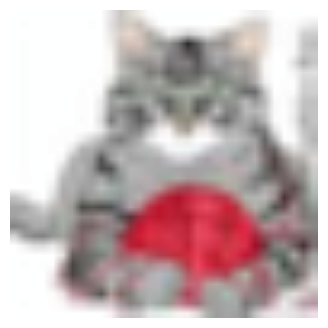

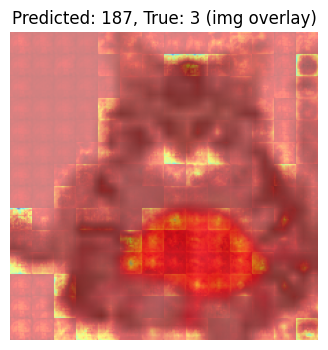

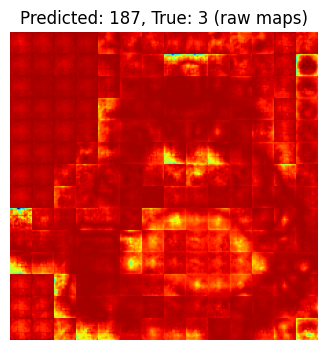

In [17]:
img_ind = 73
img_tensor = imgs_list[img_ind]
true_label = labels_list[img_ind]
total_heatmap = heatmaps[img_ind][0][0] + heatmaps[img_ind][0][1] + heatmaps[img_ind][0][2]
plot_img(img_tensor)
visualize_attributions(img_tensor.squeeze(0).detach(), total_heatmap.cpu(), title=f"Predicted: {pred_idx}, True: {true_label} (img overlay)")
visualize_attributions(img_tensor.squeeze(0).detach(), total_heatmap.cpu(), title=f"Predicted: {pred_idx}, True: {true_label} (raw maps)", show_img=False)

In [18]:
from promise import Promise
promises = list(Promise.start_nodes_to_promise.keys())
len(promises)

76